In [5]:
import pandas as pd
import matplotlib as plt
import sqlite3
import seaborn as sns

In [6]:
movie_gross = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
movie_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t')
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ANSI')
movies = pd.read_csv('zippedData/tmdb.movies.csv.gz')
movie_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
conn = sqlite3.connect('zippedData/im.db.zip')

In [7]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [8]:
movie_gross['foreign_gross'] = movie_gross['foreign_gross'].str.replace(',','')
movie_gross['foreign_gross'] = movie_gross["foreign_gross"].astype("float64")

In [9]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [10]:
movie_info['box_office'] = movie_info['box_office'].str.replace(',','')
movie_info['box_office'] = movie_info['box_office'].astype("float64")
movie_info['box_office']

0              NaN
1         600000.0
2              NaN
3              NaN
4              NaN
           ...    
1555    33886034.0
1556           NaN
1557           NaN
1558           NaN
1559           NaN
Name: box_office, Length: 1560, dtype: float64

In [11]:
for i in movie_info['currency']:
    if i is not None:
        i = 1
    else:
        i = 0
movie_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,33886034.0,106 minutes,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [12]:
movie_info.iloc[[1558]]

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101 minutes,NaN


In [13]:
movie_info['theater_date']

0        Oct 9, 1971
1       Aug 17, 2012
2       Sep 13, 1996
3        Dec 9, 1994
4                NaN
            ...     
1555    Aug 18, 2006
1556    Jul 23, 1993
1557     Jan 1, 1962
1558     Apr 1, 1993
1559    Sep 27, 2001
Name: theater_date, Length: 1560, dtype: object

In [14]:
movie_info['dvd_date']

0       Sep 25, 2001
1        Jan 1, 2013
2       Apr 18, 2000
3       Aug 27, 1997
4                NaN
            ...     
1555     Jan 2, 2007
1556    Apr 17, 2001
1557    May 11, 2004
1558    Jan 29, 2002
1559    Feb 11, 2003
Name: dvd_date, Length: 1560, dtype: object

In [15]:
movie_info['runtime']

0       104 minutes
1       108 minutes
2       116 minutes
3       128 minutes
4       200 minutes
           ...     
1555    106 minutes
1556     88 minutes
1557    111 minutes
1558    101 minutes
1559     94 minutes
Name: runtime, Length: 1560, dtype: object

In [16]:
movie_info['runtime'] = movie_info['runtime'].str.replace(' minutes','')
movie_info['runtime']  = movie_info['runtime'].astype("float64")

In [17]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB


In [18]:
reviews['rating']
# reviews['rating'] = reviews['rating'].str.replace('/5','')
#reviews['rating']  = reviews['rating'].astype("float64")
reviews.loc[reviews['rating'] != 'C']

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [19]:
reviews['fresh'] = reviews['fresh'].str.replace('fresh','1')
reviews['fresh'] = reviews['fresh'].str.replace('rotten','0')
reviews['fresh']  = reviews['fresh'].astype("float64")


In [20]:
reviews['fresh'].value_counts()

1.0    33035
0.0    21397
Name: fresh, dtype: int64

In [21]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [22]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [23]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [24]:
movie_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   float64
 4   year            3387 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 132.4+ KB


In [25]:
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace(',','')
movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].str.replace('$', '')

movie_budgets['worldwide_gross'] = movie_budgets['worldwide_gross'].astype("float64")

In [26]:
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace(',','')
movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].str.replace('$', '')

movie_budgets['domestic_gross'] = movie_budgets['domestic_gross'].astype("float64")

In [27]:
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace(',','')
movie_budgets['production_budget'] = movie_budgets['production_budget'].str.replace('$', '')
movie_budgets['production_budget'] = movie_budgets['production_budget'].astype("float64")

In [28]:
movieJoinGross = pd.DataFrame.merge(movies, movie_gross, on = 'title')
movieJoinGross

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,year
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000.0,2010
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000.0,2010
2,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,292600000.0,535700000.0,2010
3,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,BV,415000000.0,652000000.0,2010
4,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,Uni.,251500000.0,291600000.0,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2698,25090,"[16, 10751, 12]",455842,en,Elliot: The Littlest Reindeer,2.903,2018-11-30,Elliot: The Littlest Reindeer,3.4,7,Scre.,24300.0,NaN,2018
2699,25148,"[28, 12, 16]",332718,en,Bilal: A New Breed of Hero,2.707,2018-02-02,Bilal: A New Breed of Hero,6.8,54,VE,491000.0,1700000.0,2018
2700,25189,[35],498919,es,La Boda de Valentina,2.550,2018-02-09,La Boda de Valentina,6.3,7,PNT,2800000.0,NaN,2018
2701,25307,[18],470641,hi,मुक्काबाज़,2.276,2018-01-12,Mukkabaaz,7.5,18,Eros,75900.0,NaN,2018


In [29]:
movie_budgets.rename(columns = {'movie':'title'}, inplace = True)
movieJoinGrossJoinBudget = pd.DataFrame.merge(movieJoinGross, movie_budgets, on = 'title')
movieJoinGrossJoinBudget

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,studio,domestic_gross_x,foreign_gross,year,id_y,release_date_y,production_budget,domestic_gross_y,worldwide_gross
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000.0,2010,30,"Mar 26, 2010",165000000.0,217581232.0,4.948710e+08
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000.0,2010,15,"May 7, 2010",170000000.0,312433331.0,6.211564e+08
2,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,292600000.0,535700000.0,2010,38,"Jul 16, 2010",160000000.0,292576195.0,8.355246e+08
3,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,BV,415000000.0,652000000.0,2010,47,"Jun 18, 2010",200000000.0,415004880.0,1.068880e+09
4,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,Uni.,251500000.0,291600000.0,2010,50,"Jul 9, 2010",69000000.0,251513985.0,5.434646e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,24089,"[18, 36, 53]",453201,en,The 15:17 to Paris,11.576,2018-02-09,The 15:17 to Paris,5.3,799,WB,36300000.0,20800000.0,2018,23,"Feb 9, 2018",30000000.0,36276286.0,5.609620e+07
1391,24120,[35],474335,en,Uncle Drew,10.836,2018-06-29,Uncle Drew,6.5,220,LG/S,42500000.0,4200000.0,2018,85,"Jun 29, 2018",18000000.0,42469946.0,4.652716e+07
1392,24168,"[80, 18, 36, 53]",339103,en,Gotti,10.034,2018-06-15,Gotti,5.2,231,VE,4300000.0,NaN,2018,64,"Jun 15, 2018",10000000.0,4286367.0,6.089100e+06
1393,24212,"[53, 28, 80]",442064,en,Proud Mary,9.371,2018-01-12,Proud Mary,5.5,259,SGem,20900000.0,876000.0,2018,50,"Jan 12, 2018",30000000.0,20868638.0,2.170954e+07


In [30]:
movieJoinGrossJoinBudget.isna().sum()

Unnamed: 0             0
genre_ids              0
id_x                   0
original_language      0
original_title         0
popularity             0
release_date_x         0
title                  0
vote_average           0
vote_count             0
studio                 1
domestic_gross_x       2
foreign_gross        195
year                   0
id_y                   0
release_date_y         0
production_budget      0
domestic_gross_y       0
worldwide_gross        0
dtype: int64

In [31]:
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.drop('id_x', axis= 1)
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.drop('id_y', axis =1)
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.drop('release_date_y', axis= 1)
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.drop('domestic_gross_x', axis =1)
movieJoinGrossJoinBudget.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1395 non-null   int64  
 1   genre_ids          1395 non-null   object 
 2   original_language  1395 non-null   object 
 3   original_title     1395 non-null   object 
 4   popularity         1395 non-null   float64
 5   release_date_x     1395 non-null   object 
 6   title              1395 non-null   object 
 7   vote_average       1395 non-null   float64
 8   vote_count         1395 non-null   int64  
 9   studio             1394 non-null   object 
 10  foreign_gross      1200 non-null   float64
 11  year               1395 non-null   int64  
 12  production_budget  1395 non-null   float64
 13  domestic_gross_y   1395 non-null   float64
 14  worldwide_gross    1395 non-null   float64
dtypes: float64(6), int64(3), object(6)
memory usage: 174.4+ KB


In [32]:
movieJoinGrossJoinBudget.isna().sum()

Unnamed: 0             0
genre_ids              0
original_language      0
original_title         0
popularity             0
release_date_x         0
title                  0
vote_average           0
vote_count             0
studio                 1
foreign_gross        195
year                   0
production_budget      0
domestic_gross_y       0
worldwide_gross        0
dtype: int64

In [33]:
movieJoinGrossJoinBudget=movieJoinGrossJoinBudget.dropna()

In [34]:
movieJoinGrossJoinBudget.isna().sum()

Unnamed: 0           0
genre_ids            0
original_language    0
original_title       0
popularity           0
release_date_x       0
title                0
vote_average         0
vote_count           0
studio               0
foreign_gross        0
year                 0
production_budget    0
domestic_gross_y     0
worldwide_gross      0
dtype: int64

In [35]:
movieJoinGrossJoinBudget

,Unnamed: 0,genre_ids,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,studio,foreign_gross,year,production_budget,domestic_gross_y,worldwide_gross
0,1,"[14, 12, 16, 10751]",en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,277300000.0,2010,165000000.0,217581232.0,4.948710e+08
1,2,"[12, 28, 878]",en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,311500000.0,2010,170000000.0,312433331.0,6.211564e+08
2,4,"[28, 878, 12]",en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,535700000.0,2010,160000000.0,292576195.0,8.355246e+08
3,7,"[16, 10751, 35]",en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,BV,652000000.0,2010,200000000.0,415004880.0,1.068880e+09
4,8,"[16, 10751, 35]",en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,Uni.,291600000.0,2010,69000000.0,251513985.0,5.434646e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,24076,[36],en,"Paul, Apostle of Christ",12.005,2018-03-28,"Paul, Apostle of Christ",7.1,98,Affirm,5500000.0,2018,5000000.0,17547999.0,2.552950e+07
1390,24089,"[18, 36, 53]",en,The 15:17 to Paris,11.576,2018-02-09,The 15:17 to Paris,5.3,799,WB,20800000.0,2018,30000000.0,36276286.0,5.609620e+07
1391,24120,[35],en,Uncle Drew,10.836,2018-06-29,Uncle Drew,6.5,220,LG/S,4200000.0,2018,18000000.0,42469946.0,4.652716e+07
1393,24212,"[53, 28, 80]",en,Proud Mary,9.371,2018-01-12,Proud Mary,5.5,259,SGem,876000.0,2018,30000000.0,20868638.0,2.170954e+07


In [36]:
holder = movieJoinGrossJoinBudget['genre_ids'].str.split(',', n=7, expand=True)

In [37]:
holder2 = movieJoinGrossJoinBudget

In [38]:
holder3 = pd.concat([holder, holder2])

In [39]:
holder3

,0,1,2,3,4,5,6,Unnamed: 0,domestic_gross_y,foreign_gross,...,original_title,popularity,production_budget,release_date_x,studio,title,vote_average,vote_count,worldwide_gross,year
0,[14,12,16,10751],None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[12,28,878],None,None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[28,878,12],None,None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[16,10751,35],None,None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[16,10751,35],None,None,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24076.0,17547999.0,5500000.0,...,"Paul, Apostle of Christ",12.005,5000000.0,2018-03-28,Affirm,"Paul, Apostle of Christ",7.1,98.0,25529498.0,2018.0
1390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24089.0,36276286.0,20800000.0,...,The 15:17 to Paris,11.576,30000000.0,2018-02-09,WB,The 15:17 to Paris,5.3,799.0,56096200.0,2018.0
1391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24120.0,42469946.0,4200000.0,...,Uncle Drew,10.836,18000000.0,2018-06-29,LG/S,Uncle Drew,6.5,220.0,46527161.0,2018.0
1393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24212.0,20868638.0,876000.0,...,Proud Mary,9.371,30000000.0,2018-01-12,SGem,Proud Mary,5.5,259.0,21709539.0,2018.0


In [40]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5782 non-null   int64  
 1   release_date       5782 non-null   object 
 2   title              5782 non-null   object 
 3   production_budget  5782 non-null   float64
 4   domestic_gross     5782 non-null   float64
 5   worldwide_gross    5782 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 271.2+ KB


Comparing budget and profit 

In [41]:
movie_budgets["profit"] = movie_budgets['worldwide_gross'] - movie_budgets['production_budget']

In [42]:
movie_budgets.sort_values(['profit'], ascending=False)

,id,release_date,title,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",Avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09
42,43,"Dec 19, 1997",Titanic,200000000.0,659363944.0,2.208208e+09,2.008208e+09
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,1.748134e+09
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000.0,936662225.0,2.053311e+09,1.747311e+09
33,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1.648855e+09,1.433855e+09
...,...,...,...,...,...,...,...
352,53,"Apr 27, 2001",Town & Country,105000000.0,6712451.0,1.036477e+07,-9.463523e+07
341,42,"Jun 14, 2019",Men in Black: International,110000000.0,3100000.0,3.100000e+06,-1.069000e+08
193,94,"Mar 11, 2011",Mars Needs Moms,150000000.0,21392758.0,3.954976e+07,-1.104502e+08
194,95,"Dec 31, 2020",Moonfall,150000000.0,0.0,0.000000e+00,-1.500000e+08


C:\Users\clineman\Anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='production_budget', ylabel='profit'>

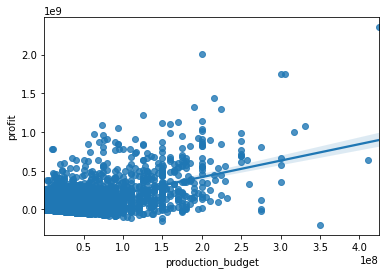

In [43]:
sns.regplot(movie_budgets['production_budget'], movie_budgets["profit"])

Comparing rating to directors

In [44]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [45]:
movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1560 non-null   int64  
 1   synopsis      1498 non-null   object 
 2   rating        1557 non-null   object 
 3   genre         1552 non-null   object 
 4   director      1361 non-null   object 
 5   writer        1111 non-null   object 
 6   theater_date  1201 non-null   object 
 7   dvd_date      1201 non-null   object 
 8   currency      340 non-null    object 
 9   box_office    340 non-null    float64
 10  runtime       1530 non-null   float64
 11  studio        494 non-null    object 
dtypes: float64(2), int64(1), object(9)
memory usage: 146.4+ KB


In [46]:
movies

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [47]:
movie_info

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104.0,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,600000.0,108.0,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116.0,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128.0,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,33886034.0,106.0,New Line Cinema
1556,1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88.0,Paramount Vantage
1557,1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111.0,NaN
1558,1999,The Sandlot is a coming-of-age story about a g...,PG,Comedy|Drama|Kids and Family|Sports and Fitness,David Mickey Evans,David Mickey Evans|Robert Gunter,"Apr 1, 1993","Jan 29, 2002",NaN,NaN,101.0,NaN


In [48]:
reviews

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,1.0,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,0.0,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,1.0,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,1.0,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,1.0,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,1.0,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,0.0,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,0.0,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,0.0,Christopher Null,0,Filmcritic.com,"September 7, 2003"
